In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import cv2
import os
import torchvision

torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
# Module for checking if has face
# training input: images with face, image without face
# training label: {if has face, rect_top, rect_bottom, rect_left, rect_right} 

# load labels
train_lbls1 = {}
def loadHeadLbls1():
    head_lbls_path = "./Datasets/lbls_p1.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2,3,4,5], skiprows=1)
    for i in range(head_lbls_name.size):
        train_lbls1[head_lbls_name[i]] = head_lbls_val[i] / np.array([1,128,128,128,128])
    #next
#end def
loadHeadLbls1()
#print(train_lbls1)

# NN data loader
class HasFaceSet(Dataset):    
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next
        self.hasFaceCount = len(list_input)

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_GRAYSCALE)  #IMREAD_COLOR
        
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        
        if (idx < self.hasFaceCount):
            lbl = train_lbls1[self.shortNames[idx]]
        #endif
        return image, lbl

train_image_path = "./Datasets/train_has_face/"
hasFace_dataset = HasFaceSet(train_image_path)
hasFaceDL = DataLoader(hasFace_dataset,shuffle=True,batch_size=1,num_workers=0)

# load validation labels
valid_lbls1 = {}
def loadHeadLbls1Valid():
    head_lbls_path = "./Datasets/lbls_p1_valid.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2,3,4,5], skiprows=1)
    for i in range(head_lbls_name.size):
        valid_lbls1[head_lbls_name[i]] = head_lbls_val[i] / np.array([1,128,128,128,128])
    #next
#end def
loadHeadLbls1Valid()
#print(valid_lbls1)

# NN validation data loader
class HasFaceValidationSet(Dataset):
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_GRAYSCALE)  #IMREAD_COLOR
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        lbl = valid_lbls1[self.shortNames[idx]]
        return image, lbl

valid_image_path = "./Datasets/validation/"
hasFace_dataset_valid = HasFaceValidationSet(valid_image_path)
hasFaceValidDL = DataLoader(hasFace_dataset_valid,shuffle=True,batch_size=1,num_workers=0)


In [13]:
# NN architecture

class HasFaceNN(Module):
    def __init__(self):
        super(HasFaceNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(1,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(16*29*29,256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
            )
    def encoder(self,image):
        code = self.enc1(image)
        code = code.view(-1, 16*29*29)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        code = self.encoder(image)
        return code

def reconstruction_loss(input,target):
    loss_func = nn.MSELoss()
    recon_loss = loss_func(input, target)
    return recon_loss

hasFaceModel = HasFaceNN()
hasFaceOptimizer = torch.optim.Adam(hasFaceModel.parameters(), lr=0.001) 
#myOptimizer3 = torch.optim.SGD(hasFace2Model.parameters(), lr=0.1, momentum=0.05)    #torch.optim.Adam(hasFace2Model.parameters(), lr=0.1) 

ep:0	training:1169.4934538099915	validation:277.52748038619757
ep:1	training:989.4852245342918	validation:225.08214740082622
ep:2	training:459.8583215265535	validation:111.87405418604612
ep:3	training:664.5131609693635	validation:70.25090121896937
ep:4	training:262.8529165267537	validation:67.34511943068355
ep:5	training:187.97638185787946	validation:41.89154243795201
ep:6	training:125.79369663035322	validation:38.00587735895533
ep:7	training:230.4693396872608	validation:65.47325139399618
ep:8	training:102.47982532200695	validation:17.625549691729248
ep:9	training:151.9616402633801	validation:49.19027460709913
ep:10	training:49.67857089286554	validation:16.526532868738286
ep:11	training:26.163189070757653	validation:15.463457537407521
ep:12	training:22.572407145162288	validation:10.139901307411492
ep:13	training:77.49481635505617	validation:27.14147920778487
ep:14	training:75.97613202233333	validation:33.413149969419464


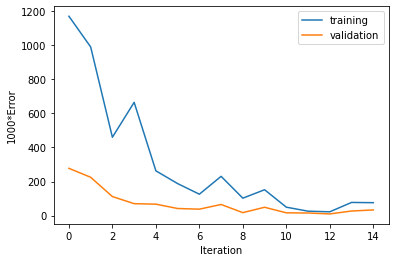

In [14]:
ys = []
zs = []
xs = np.arange(15)

epochs = 15
for ep in range(epochs):
    for i,data in enumerate(hasFaceDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(5)
        dataOut = hasFaceModel(dataIn)
        dataOut = dataOut.view(5)
        loss = reconstruction_loss(dataOut, labelIn.float())
        
        hasFaceOptimizer.zero_grad()
        loss.backward()
        hasFaceOptimizer.step()
    
    total_loss = 0.0
    for i,data in enumerate(hasFaceDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(5)
        dataOut = hasFaceModel(dataIn)
        dataOut = dataOut.view(5)
        loss = reconstruction_loss(dataOut, labelIn.float())
        total_loss += loss.item()
    
    total_loss *= 1000
    val_loss = 0.0
    for i,data in enumerate(hasFaceValidDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(5)
        dataOut = hasFaceModel(dataIn)
        dataOut = dataOut.view(5)
        loss = reconstruction_loss(dataOut, labelIn.float())
        val_loss += loss.item()
    
    val_loss *= 1000
    print('ep:' + str(ep) + '\t'+ 'training:' + str(total_loss) + '\t' + 'validation:' + str(val_loss))
    ys.append(total_loss)
    zs.append(val_loss)
    if total_loss < 50.0 and val_loss < 20.0:
        #break
        print("here")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('1000*Error')
plt.plot(xs, ys, label='training')
plt.plot(xs, zs, label='validation')
plt.legend()

In [5]:
test_img_path = "./Datasets/head_pos2/ss000.png"

test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

trans = torchvision.transforms.ToTensor()
test_img = trans(test_img)

test_img = test_img.unsqueeze(0)

test_out = hasFaceModel(test_img)
test_out = test_out.detach().numpy()
test_out *= np.array([1,128,128,128,128])
print(test_out)

[[ 0.9199001 44.558563  93.547035  35.466045  78.35769  ]]


In [6]:
torch.save(hasFaceModel, "./Models/model_hasface")


In [15]:
# crop the raw image to face rect of 256*256

img640_paths = os.listdir("./Datasets/train640/")
for i in range(0,len(img640_paths)):
    path = os.path.join("./Datasets/train640/", img640_paths[i])
    src_img = cv2.imread(path, cv2.IMREAD_COLOR)
    test_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.resize(test_img, (128,128))
    trans = torchvision.transforms.ToTensor()
    test_img = trans(test_img)
    test_img = test_img.unsqueeze(0)
    
    test_out = hasFaceModel(test_img)
    test_out = test_out.detach().numpy()
    test_out = test_out[0]
    if (test_out[0] <= 0.5):
        continue
    #end if
    test_out *= 640.0
    #print(test_out)
    
    centx = (test_out[3] + test_out[4]) * 0.5
    centy = (test_out[1] + test_out[2]) * 0.5
    r = max(centx - test_out[3], centy - test_out[1])
    
    top = int(centy-r)
    if (top<0):
        top = 0

    bottom = int(centy+r)
    if (bottom>=640):
        bottom = 639

    left = int(centx-r)
    if (left<0):
        left = 0

    right = int(centx+r) 
    if (right>=640):
        right = 639

    
    cut_img = src_img[top:bottom, left:right]
    cut_img = cv2.resize(cut_img, (256,256))
    out_path = os.path.join("./Datasets/train256/", img640_paths[i])
    cv2.imwrite(out_path, cut_img)
#next


In [16]:
# Module for detecting face landmark
# training input: face regeion of 256*256
# training label: {nose, mouthL, mouthR, lip1, lip2, lip3, lip4, chin, chinL, chinR, earL, earR} 


# load labels
train_lbls2 = {}
def loadHeadLbls2():
    head_lbls_path = "./Datasets/lbls_p2_s.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=np.arange(1,17), skiprows=1)
    for i in range(head_lbls_name.size):
        train_lbls2[head_lbls_name[i]] = head_lbls_val[i] / (np.ones(16))
    #next
#end def
loadHeadLbls2()
#print(train_lbls2)

# NN data loader
class LandmarkSet(Dataset):    
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next
        self.hasFaceCount = len(list_input)

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR
        
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        
        if (idx < self.hasFaceCount):
            lbl = train_lbls2[self.shortNames[idx]]
        #endif
        return image, lbl

train_image_path = "./Datasets/train_landmark/"
landmark_dataset = LandmarkSet(train_image_path)
landmarkDL = DataLoader(landmark_dataset,shuffle=True,batch_size=1,num_workers=0)

# NN validation data loader
class LandmarkValidationSet(Dataset):
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        lbl = train_lbls2[self.shortNames[idx]]
        return image, lbl

valid_image_path = "./Datasets/validation_landmark/"
landmark_dataset_valid = LandmarkValidationSet(valid_image_path)
landmarkValidDL = DataLoader(landmark_dataset_valid,shuffle=True,batch_size=1,num_workers=0)


In [19]:
# NN architecture

class LandmarkNN(Module):
    def __init__(self):
        super(LandmarkNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,24,7,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48,60,3),
            nn.ReLU(),
            nn.Conv2d(60,60,3),
            nn.ReLU(),
            nn.Conv2d(60,48,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(48*27*27,1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 16)
            )
    def encoder(self,image):
        code = self.enc1(image)
        code = code.view(-1, 48*27*27)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        code = self.encoder(image)
        return code

def reconstruction_loss(input,target):
    loss_func = nn.MSELoss()
    recon_loss = loss_func(input, target)
    return recon_loss

landmarkModel = LandmarkNN()
landmarkOptimizer = torch.optim.Adam(landmarkModel.parameters(), lr=0.001) 
#landmarkOptimizer = torch.optim.SGD(landmarkModel.parameters(), lr=0.01, momentum=0.05)


ep:0	training:512.3262343695387	validation:60.16865372657776
ep:1	training:531.2469695927575	validation:70.59686514548957
ep:2	training:611.997440457344	validation:92.11292816326022
ep:3	training:359.3353608157486	validation:61.29237310960889
ep:4	training:298.0766035616398	validation:39.690260076895356
ep:5	training:278.6291079246439	validation:40.33667652402073
ep:6	training:205.22205365705304	validation:34.585250075906515
ep:7	training:219.7441291064024	validation:26.436303509399295
ep:8	training:131.23534817714244	validation:18.64228182239458
ep:9	training:127.34271894441918	validation:19.437431619735435
ep:10	training:173.00335713662207	validation:34.458682232070714
ep:11	training:94.23802484525368	validation:19.213186169508845
ep:12	training:260.6316732708365	validation:45.73018604423851
ep:13	training:205.9201782103628	validation:49.16620790027082
ep:14	training:105.2300244482467	validation:17.327288558590226
ep:15	training:95.07188419229351	validation:21.755061141448095
ep:16	t

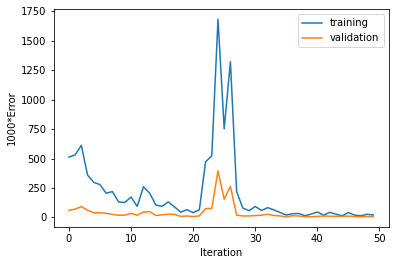

In [20]:
ys = []
zs = []
xs = np.arange(50)

epochs = 50
for ep in range(epochs):
    for i,data in enumerate(landmarkDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(16)
        dataOut = landmarkModel(dataIn)
        dataOut = dataOut.view(16)
        loss = reconstruction_loss(dataOut, labelIn.float())
        
        landmarkOptimizer.zero_grad()
        loss.backward()
        landmarkOptimizer.step()
    
    total_loss = 0.0
    for i,data in enumerate(landmarkDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(16)
        dataOut = landmarkModel(dataIn)
        dataOut = dataOut.view(16)
        loss = reconstruction_loss(dataOut, labelIn.float())
        total_loss += loss.item()
    
    total_loss *= 1000
    val_loss = 0.0
    for i,data in enumerate(landmarkValidDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(16)
        dataOut = landmarkModel(dataIn)
        dataOut = dataOut.view(16)
        loss = reconstruction_loss(dataOut, labelIn.float())
        val_loss += loss.item()
    
    val_loss *= 1000
    print('ep:' + str(ep) + '\t'+ 'training:' + str(total_loss) + '\t' + 'validation:' + str(val_loss))
    ys.append(total_loss)
    zs.append(val_loss)
    if total_loss < 10.0 and val_loss < 10.0:
        #break
        print("here")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('1000*Error')
plt.plot(xs, ys, label='training')
plt.plot(xs, zs, label='validation')
plt.legend()

In [44]:
test_img_path = "./Datasets/train256/ss133.png"

test_img = cv2.imread(test_img_path, cv2.IMREAD_COLOR)

trans = torchvision.transforms.ToTensor()
test_img = trans(test_img)

test_img = test_img.unsqueeze(0)

test_out = landmarkModel(test_img)
test_out = test_out.detach().numpy()
#test_out *= np.array([1,128,128,128,128])
print(test_out)

[[0.6579102  0.4084445  0.52549624 0.61213255 0.71766025 0.63245195
  0.6491751  0.5528758  0.63638055 0.5958406  0.6332371  0.6176875
  0.64130175 0.6654912  0.61286926 0.8227003  0.5059347  0.8037097
  0.6974129  0.79444134 0.26191396 0.6440436  0.8179154  0.6359533 ]]


In [45]:
torch.save(landmarkModel, "./Models/model_landmark")

In [33]:
# Module for facial expression
# training input: landmarks
# training label: {smile, sad, surprise} 


# load labels
train_lbls3 = {}
def loadHeadLbls3():
    head_lbls_path = "./Datasets/lbls_p3.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2,3], skiprows=1)
    for i in range(head_lbls_name.size):
        train_lbls3[i] = head_lbls_val[i] / (np.ones(3))
    #next
#end def
loadHeadLbls3()

# load data
train_data3 = {}
def loadHeadData3():
    head_lbls_path = "./Datasets/data_p3.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=np.arange(1,17), skiprows=1)
    for i in range(head_lbls_name.size):
        train_data3[i] = head_lbls_val[i] / (np.ones(16))
    #next
#end def
loadHeadData3()

# NN data loader
class ExpressionSet(Dataset):    
    def __init__(self, landmarkIn):
        self.landmarkData = landmarkIn
        self.hasFaceCount = len(landmarkIn)

    def __len__(self):
        length = len(self.landmarkData)
        return length

    def __getitem__(self, idx):
        lm = self.landmarkData[idx]
        trans = torchvision.transforms.ToTensor()
        #lm = trans(lm)
        lbl = train_lbls3[idx]
        return lm, lbl

expression_dataset = ExpressionSet(train_data3)
expressionDL = DataLoader(expression_dataset,shuffle=True,batch_size=1,num_workers=0)

valid_lbls3 = {}
def loadHeadLbls3Valid(): 
    head_lbls_path = "./Datasets/lbls_p3_valid.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2,3], skiprows=1)
    for i in range(head_lbls_name.size):
        valid_lbls3[i] = head_lbls_val[i] / (np.ones(3))
    #next
#end def
loadHeadLbls3Valid()

# load data
valid_data3 = {}
def loadHeadData3Valid():
    head_lbls_path = "./Datasets/data_p3_valid.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=np.arange(1,17), skiprows=1)
    for i in range(head_lbls_name.size):
        valid_data3[i] = head_lbls_val[i] / (np.ones(16))
    #next
#end def
loadHeadData3Valid()

# NN validation data loader
class ExpressionValidationSet(Dataset):    
    def __init__(self, landmarkIn):
        self.landmarkData = landmarkIn
        self.hasFaceCount = len(landmarkIn)

    def __len__(self):
        length = len(self.landmarkData)
        return length

    def __getitem__(self, idx):
        lm = self.landmarkData[idx]
        trans = torchvision.transforms.ToTensor()
        #lm = trans(lm)
        lbl = valid_lbls3[idx]
        return lm, lbl

expression_dataset_valid = ExpressionValidationSet(valid_data3)
expressionValidDL = DataLoader(expression_dataset_valid,shuffle=True,batch_size=1,num_workers=0)



In [48]:
# NN architecture

class ExpressionNN(Module):
    def __init__(self):
        super(ExpressionNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Linear(16,60),
            nn.ReLU(),
            nn.Linear(60,300),
            nn.ReLU(),
            nn.Linear(300,240),
            nn.ReLU(),
            )
        self.enc2 = nn.Sequential(
            nn.Linear(240,240),
            nn.ReLU(),
            nn.Linear(240,240),
            nn.ReLU()
            )
        self.enc3 = nn.Sequential(
            nn.Linear(240,200),
            nn.Dropout(0.2),
            nn.Linear(200,3)
            )
    
    def encoder(self,dataIn):
        dataIn = dataIn.float()
        code1 = self.enc1(dataIn)
        code2 = self.enc2(code1)
        code2 += code1
        code3 = self.enc2(code2)
        code3 += code2
        code4 = self.enc3(code3)
        return code4
    
    def forward(self,dataIn):
        code = self.encoder(dataIn)
        return code

def reconstruction_loss(input,target):
    loss_func = nn.MSELoss()
    recon_loss = loss_func(input, target)
    return recon_loss

expressionModel = ExpressionNN()
expressionOptimizer = torch.optim.Adam(expressionModel.parameters(), lr=0.0001) 
#expressionOptimizer = torch.optim.SGD(expressionModel.parameters(), lr=0.0001, momentum=0.05)

ep:0	training:3381.7222667858005	validation:771.8231119215488
ep:1	training:3253.6030281335115	validation:740.0363869965076
ep:2	training:3370.4287400469184	validation:795.059422031045
ep:3	training:3391.452225856483	validation:781.386960297823
ep:4	training:3358.408742584288	validation:791.7258404195309
ep:5	training:3235.993158072233	validation:731.37042298913
ep:6	training:3350.1570830121636	validation:699.8525559902191
ep:7	training:3322.32666015625	validation:743.0616337805986
ep:8	training:3345.6283500418067	validation:766.8817583471537
ep:9	training:3433.953432366252	validation:748.120492324233
ep:10	training:3356.289016082883	validation:766.280185431242
ep:11	training:3240.136221051216	validation:761.0170263797045
ep:12	training:3327.9749657958746	validation:760.2085843682289
ep:13	training:3453.1921446323395	validation:768.8595503568649
ep:14	training:3303.05930133909	validation:757.9014003276825
ep:15	training:3271.175512112677	validation:782.4120298027992
ep:16	training:3287

ep:132	training:2472.499096998945	validation:697.0659773796797
ep:133	training:2463.3389529772103	validation:733.6984723806381
ep:134	training:2372.8592530824244	validation:714.9067595601082
ep:135	training:2370.030778925866	validation:772.8033736348152
ep:136	training:2593.8848803343717	validation:839.5326510071754
ep:137	training:2415.2703499421477	validation:688.5307095944881
ep:138	training:2583.7607351131737	validation:767.7056705579162
ep:139	training:2728.3905079821125	validation:825.8955124765635
ep:140	training:2244.613795308396	validation:721.6589599847794
ep:141	training:2366.372704040259	validation:733.5588857531548
ep:142	training:2692.604778741952	validation:823.891875334084
ep:143	training:2550.8264175150543	validation:781.2309972941875
ep:144	training:2181.2829804839566	validation:728.8618292659521
ep:145	training:2127.015237696469	validation:751.3880468904972
ep:146	training:2147.8122079279274	validation:737.3629305511713
ep:147	training:2549.001374747604	validation:72

ep:262	training:494.9445820529945	validation:407.6575911603868
ep:263	training:839.665588340722	validation:533.3553468808532
ep:264	training:1159.6935887937434	validation:437.289223074913
ep:265	training:511.5436595515348	validation:405.94326378777623
ep:266	training:537.0028299512342	validation:372.80308129265904
ep:267	training:522.750041767722	validation:416.4087329991162
ep:268	training:531.7441050428897	validation:532.1234506554902
ep:269	training:430.8950951672159	validation:469.3499431014061
ep:270	training:391.84501800627913	validation:495.95952266827226
ep:271	training:2094.161176829971	validation:649.6752565726638
ep:272	training:1359.8238789709285	validation:697.3655539331958
ep:273	training:795.4940322670154	validation:460.21480206400156
ep:274	training:843.177463975735	validation:590.4800118878484
ep:275	training:621.1219177930616	validation:389.1826714389026
ep:276	training:1019.0506759099662	validation:560.0518947467208
ep:277	training:1275.2795492997393	validation:734.1

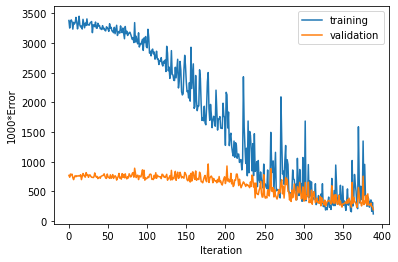

In [49]:
ys = []
zs = []
xs = []

epochs = 1000
for ep in range(epochs):
    for i,data in enumerate(expressionDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        
        expressionOptimizer.zero_grad()
        loss.backward()
        expressionOptimizer.step()
    
    total_loss = 0.0
    for i,data in enumerate(expressionDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        total_loss += loss.item()
    
    total_loss *= 1000
    val_loss = 0.0
    for i,data in enumerate(expressionValidDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        val_loss += loss.item()
    
    val_loss *= 1000
    print('ep:' + str(ep) + '\t'+ 'training:' + str(total_loss) + '\t' + 'validation:' + str(val_loss))
    xs.append(ep)
    ys.append(total_loss)
    zs.append(val_loss)
    if total_loss < 1000.0 and val_loss < 200.0:
        break
        print("here")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('1000*Error')
plt.plot(xs, ys, label='training')
plt.plot(xs, zs, label='validation')
plt.legend()

In [50]:
test_img = [0.4475,0.51,0.3975,0.7,0.6175,0.68,0.465,0.6525,0.4775,0.6875,0.4825,0.72,0.48,0.7775,0.5275,0.8975]
test_img = np.array(test_img)
test_img = torch.from_numpy(test_img)

test_out = expressionModel(test_img)
test_out = test_out.detach().numpy()
#test_out *= np.array([1,128,128,128,128])
print(test_out)

# 0.5, 0, 0.5

[0.29329976 0.00737349 0.4230529 ]


In [51]:
torch.save(expressionModel, "./Models/model_expression")


In [52]:
# Module for mouth region
# training input: image 256x256
# training label: {pos} 


# load labels
train_lbls2m = {}
def loadHeadLbls2m():
    head_lbls_path = "./Datasets/lbls_mouth.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2], skiprows=1)
    for i in range(head_lbls_name.size):
        train_lbls2m[head_lbls_name[i]] = head_lbls_val[i] / (np.ones(2))
    #next
#end def
loadHeadLbls2m()
print(train_lbls2m)

# NN data loader
class MouthSet(Dataset):    
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next
        self.hasFaceCount = len(list_input)

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR5
        image = cv2.resize(image, (128,128))
        
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        
        if (idx < self.hasFaceCount):
            lbl = train_lbls2m[self.shortNames[idx]]
        #endif
        return image, lbl

train_image_path = "./Datasets/train_landmark/"
landmark_dataset = MouthSet(train_image_path)
landmarkDL = DataLoader(landmark_dataset,shuffle=True,batch_size=1,num_workers=0)

# NN validation data loader
class MouthValidationSet(Dataset):
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR
        image = cv2.resize(image, (128,128))
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        lbl = train_lbls2m[self.shortNames[idx]]
        return image, lbl

valid_image_path = "./Datasets/validation_landmark/"
landmark_dataset_valid = MouthValidationSet(valid_image_path)
landmarkValidDL = DataLoader(landmark_dataset_valid,shuffle=True,batch_size=1,num_workers=0)


{'ss001.png': array([0.3975, 0.7275]), 'ss002.png': array([0.6075, 0.7225]), 'ss003.png': array([0.3825, 0.69  ]), 'ss004.png': array([0.555, 0.74 ]), 'ss005.png': array([0.7725, 0.66  ]), 'ss006.png': array([0.6675, 0.79  ]), 'ss009.png': array([0.46  , 0.5125]), 'ss010.png': array([0.545, 0.495]), 'ss011.png': array([0.2675, 0.5525]), 'ss012.png': array([0.555 , 0.8175]), 'ss013.png': array([0.63  , 0.7325]), 'ss014.png': array([0.6025, 0.735 ]), 'ss017.png': array([0.5775, 0.8125]), 'ss018.png': array([0.6775, 0.69  ]), 'ss019.png': array([0.6025, 0.68  ]), 'ss020.png': array([0.495, 0.705]), 'ss021.png': array([0.63  , 0.7225]), 'ss022.png': array([0.52, 0.64]), 'ss025.png': array([0.61 , 0.715]), 'ss026.png': array([0.535, 0.78 ]), 'ss027.png': array([0.6025, 0.7225]), 'ss028.png': array([0.6275, 0.69  ]), 'ss029.png': array([0.5775, 0.7375]), 'ss030.png': array([0.49, 0.82]), 'ss033.png': array([0.59  , 0.7125]), 'ss034.png': array([0.4875, 0.715 ]), 'ss035.png': array([0.585 , 0

In [55]:
# NN architecture

class MouthNN(Module):
    def __init__(self):
        super(MouthNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(16*30*30,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
            )
    def encoder(self,image):
        code = self.enc1(image)
        code = code.view(-1, 16*30*30)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        code = self.encoder(image)
        return code

def reconstruction_loss(input,target):
    loss_func = nn.MSELoss()
    recon_loss = loss_func(input, target)
    return recon_loss

mouthModel = MouthNN()
mouthOptimizer = torch.optim.Adam(mouthModel.parameters(), lr=0.0005) 
#landmarkOptimizer = torch.optim.SGD(landmarkModel.parameters(), lr=0.01, momentum=0.05)


ep:0	training:280.36148405226413	validation:32.577471567492466
ep:1	training:868.3532616123557	validation:165.38170678541064
ep:2	training:291.99097692617215	validation:57.54601443186402
ep:3	training:138.40226476895623	validation:11.491632059914991
ep:4	training:165.41710792807862	validation:33.40146620757878
ep:5	training:133.0848831203184	validation:31.376140599604696
ep:6	training:86.9310505950125	validation:24.600196862593293
ep:7	training:43.57718944083899	validation:14.081411645747721
ep:8	training:14.723908821451914	validation:5.163058651305619
ep:9	training:18.93392605416011	validation:4.83721650471125
ep:10	training:6.406710477676825	validation:4.857775646087248
ep:11	training:10.727128094231375	validation:7.146836098399945
ep:12	training:10.112205199405366	validation:3.753629221137089
ep:13	training:5.158088616553869	validation:3.663891731775948
ep:14	training:10.057958403194789	validation:6.567191165231634
ep:15	training:1.131220218738349	validation:3.634204963191223
ep:16	

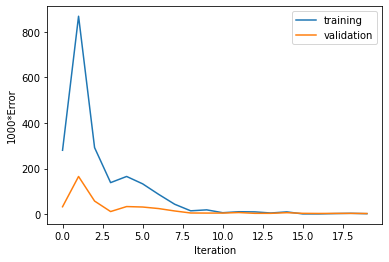

In [56]:
ys = []
zs = []
xs = []

epochs = 100
for ep in range(epochs):
    for i,data in enumerate(landmarkDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(2)
        dataOut = mouthModel(dataIn)
        dataOut = dataOut.view(2)
        loss = reconstruction_loss(dataOut, labelIn.float())
        
        mouthOptimizer.zero_grad()
        loss.backward()
        mouthOptimizer.step()
    
    total_loss = 0.0
    for i,data in enumerate(landmarkDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(2)
        dataOut = mouthModel(dataIn)
        dataOut = dataOut.view(2)
        loss = reconstruction_loss(dataOut, labelIn.float())
        total_loss += loss.item()
    
    total_loss *= 1000
    val_loss = 0.0
    for i,data in enumerate(landmarkValidDL):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(2)
        dataOut = mouthModel(dataIn)
        dataOut = dataOut.view(2)
        loss = reconstruction_loss(dataOut, labelIn.float())
        val_loss += loss.item()
    
    val_loss *= 1000
    print('ep:' + str(ep) + '\t'+ 'training:' + str(total_loss) + '\t' + 'validation:' + str(val_loss))
    xs.append(ep)
    ys.append(total_loss)
    zs.append(val_loss)
    if total_loss < 3.0 and val_loss < 3.0:
        break

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('1000*Error')
plt.plot(xs, ys, label='training')
plt.plot(xs, zs, label='validation')
plt.legend()

In [84]:
torch.save(mouthModel, "./Models/model_mouth")


In [89]:
# crop the raw image to face rect of 256*256

img256_paths = os.listdir("./Datasets/train256/")
for i in range(0,len(img256_paths)):
    path = os.path.join("./Datasets/train256/", img256_paths[i])
    src_img = cv2.imread(path, cv2.IMREAD_COLOR)
    test_img = cv2.resize(src_img, (128,128))
    trans = torchvision.transforms.ToTensor()
    test_img = trans(test_img)
    test_img = test_img.unsqueeze(0)
    
    test_out = mouthModel(test_img)
    test_out = test_out.detach().numpy()
    test_out = test_out[0]
    
    test_out *= 256.0
    
    centx = test_out[0]
    centy = test_out[1]
    r = 24
    
    top = int(centy-r)
    if (top<0):
        top = 0

    bottom = int(centy+r)
    if (bottom>=256):
        bottom = 255

    left = int(centx-r)
    if (left<0):
        left = 0

    right = int(centx+r) 
    if (right>=256):
        right = 255

    
    cut_img = src_img[top:bottom, left:right]
    cut_img = cv2.resize(cut_img, (64,64))
    out_path = os.path.join("./Datasets/train64/", img256_paths[i])
    cv2.imwrite(out_path, cut_img)
#next


In [57]:
# Module for facial expression from mouth image
# training input: image 64x64
# training label: {smile, sad, surprise} 


# load labels
train_lbls3m = {}
def loadHeadLbls3m():
    head_lbls_path = "./Datasets/lbls_p3_m.txt"
    head_lbls_name = np.loadtxt(head_lbls_path, delimiter=',', usecols=[0], skiprows=1, dtype=str)
    head_lbls_val = np.loadtxt(head_lbls_path, delimiter=',', usecols=[1,2,3], skiprows=1)
    for i in range(head_lbls_name.size):
        train_lbls3m[head_lbls_name[i]] = head_lbls_val[i] / (np.ones(3))
    #next
#end def
loadHeadLbls3m()

# NN data loader
class ExpressionSet2(Dataset):    
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next
        self.hasFaceCount = len(list_input)

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR
        
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        
        if (idx < self.hasFaceCount):
            lbl = train_lbls3m[self.shortNames[idx]]
        #endif
        return image, lbl

train_image_path = "./Datasets/train_mouth/"
expression_dataset2 = ExpressionSet2(train_image_path)
expressionDL2 = DataLoader(expression_dataset2,shuffle=True,batch_size=1,num_workers=0)

# NN validation data loader
class ExpressionValidationSet2(Dataset):
    def __init__(self, face_path=""):
        self.imgPaths = []
        self.shortNames = []
        list_input = os.listdir(face_path)
        for i in range(0,len(list_input)):
            path = os.path.join(face_path, list_input[i])
            self.imgPaths.append(path)
            self.shortNames.append(list_input[i])
        #next

    def __len__(self):
        length = len(self.imgPaths)
        return length

    def __getitem__(self, idx):
        image = cv2.imread(self.imgPaths[idx], cv2.IMREAD_COLOR)  #IMREAD_COLOR
        trans = torchvision.transforms.ToTensor()
        image = trans(image)
        lbl = train_lbls3m[self.shortNames[idx]]
        return image, lbl

valid_image_path = "./Datasets/validation_mouth/"
expression_dataset_valid2 = ExpressionValidationSet2(valid_image_path)
expressionValidDL2 = DataLoader(expression_dataset_valid2,shuffle=True,batch_size=1,num_workers=0)


In [58]:
# NN architecture

class ExpressionNN2(Module):
    def __init__(self):
        super(ExpressionNN2, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(16*13*13,256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
            )
    def encoder(self,image):
        code = self.enc1(image)
        code = code.view(-1, 16*13*13)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        code = self.encoder(image)
        return code

def reconstruction_loss(input,target):
    loss_func = nn.MSELoss()
    recon_loss = loss_func(input, target)
    return recon_loss

expressionModel2 = ExpressionNN2()
#expressionOptimizer2 = torch.optim.Adam(expressionModel2.parameters(), lr=0.01) 
expressionOptimizer2 = torch.optim.SGD(expressionModel2.parameters(), lr=0.01, momentum=0.05)


ep:0	training:7209.421133622527	validation:1195.0301323086023
ep:1	training:5827.478418126702	validation:968.7394984066486
ep:2	training:5396.527998149395	validation:903.0570946633816
ep:3	training:5392.267853021622	validation:854.1635535657406
ep:4	training:5343.017287552357	validation:868.4820272028446
ep:5	training:5200.119813904166	validation:832.3179073631763
ep:6	training:5100.4568710923195	validation:833.1393077969551
ep:7	training:5119.87732630223	validation:843.0048748850822
ep:8	training:4967.6064979285	validation:781.0109779238701
ep:9	training:4871.075672097504	validation:785.8256809413433
ep:10	training:4817.255944944918	validation:825.8810341358185
ep:11	training:4770.161020569503	validation:709.9355161190033
ep:12	training:4773.8233637064695	validation:658.5545614361763
ep:13	training:4580.559409223497	validation:764.8754045367241
ep:14	training:4409.057943150401	validation:581.3774839043617
ep:15	training:4088.8638412579894	validation:630.8233551681042
ep:16	training:39

ep:131	training:600.5079972674139	validation:132.91755854152143
ep:132	training:574.0993539220653	validation:151.35518787428737
ep:133	training:729.1841709811706	validation:277.51485304906964
ep:134	training:585.2038332959637	validation:167.45196154806763
ep:135	training:635.4995457222685	validation:175.3825640771538
ep:136	training:534.3664581305347	validation:154.66951788403094
ep:137	training:781.533866917016	validation:176.46746430546045
ep:138	training:587.1774556580931	validation:136.18518505245447
ep:139	training:639.1178796184249	validation:152.71599381230772
ep:140	training:539.4247711519711	validation:148.41958158649504
ep:141	training:497.97781865345314	validation:115.48535106703639
ep:142	training:600.6449909546063	validation:149.49504798278213
ep:143	training:440.2368171722628	validation:156.5713225863874
ep:144	training:531.67959782877	validation:105.30395724344999
ep:145	training:623.2219049561536	validation:159.70079015824012
ep:146	training:548.7671176961157	validation

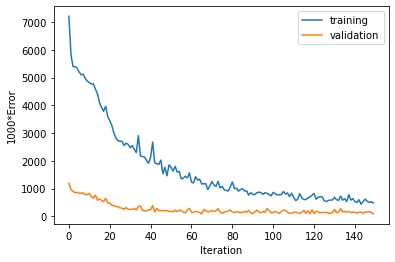

In [59]:
ys = []
zs = []
xs = []

epochs = 1000
for ep in range(epochs):
    for i,data in enumerate(expressionDL2):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel2(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        
        expressionOptimizer2.zero_grad()
        loss.backward()
        expressionOptimizer2.step()
    
    total_loss = 0.0
    for i,data in enumerate(expressionDL2):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel2(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        total_loss += loss.item()
    
    total_loss *= 1000
    val_loss = 0.0
    for i,data in enumerate(expressionValidDL2):
        dataIn, labelIn = data
        labelIn = labelIn.unsqueeze(0)
        labelIn = labelIn.view(3)
        dataOut = expressionModel2(dataIn)
        dataOut = dataOut.view(3)
        loss = reconstruction_loss(dataOut, labelIn.float())
        val_loss += loss.item()
    
    val_loss *= 1000
    print('ep:' + str(ep) + '\t'+ 'training:' + str(total_loss) + '\t' + 'validation:' + str(val_loss))
    xs.append(ep)
    ys.append(total_loss)
    zs.append(val_loss)
    if total_loss < 500.0 and val_loss < 100.0:
        break
    
plt.figure()
plt.xlabel('Iteration')
plt.ylabel('1000*Error')
plt.plot(xs, ys, label='training')
plt.plot(xs, zs, label='validation')
plt.legend()


In [60]:
test_img_path = "./Datasets/train64/ss133.png"

test_img = cv2.imread(test_img_path, cv2.IMREAD_COLOR)

trans = torchvision.transforms.ToTensor()
test_img = trans(test_img)

test_img = test_img.unsqueeze(0)

test_out = expressionModel2(test_img)
test_out = test_out.detach().numpy()
#test_out *= np.array([1,128,128,128,128])
print(test_out)

[[0.0269791  0.01627064 1.0401211 ]]


In [61]:
torch.save(expressionModel2, "./Models/model_expression2")
